<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-filip-martin/blob/main/result_visualization/Result_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluace a visualizace výsledků


## Předpříprava dat pro evaluaci
- Vstupem je zvukový soubor ve formátu flack
- Výstupem je set spectogramů uložených v .h5 souboru

### Předpříprava zvukového signálu
- Převedení do mono
- Resamoplování sampling rate

### Příprava spektrogramů
- Rozpadneme signál na 2s dlouhé části s overlapem
- Napočítáme spectogramy 128x128
- Normalizujeme spektrogramy
- Uložíme je do h5 souboru

In [ ]:
import os
import numpy as np
import torch
import torchaudio
import h5py
from scipy.ndimage import zoom

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def resample_audio_torchaudio(input_file, target_sample_rate=44100):
    """
    Resample an audio file to the target sampling rate.
    """
    waveform, sample_rate = torchaudio.load(input_file)
    waveform = waveform.to(device)

    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate).to(device)
        waveform = resampler(waveform)
        sample_rate = target_sample_rate

    if waveform.shape[0] > 1:  # Convert to mono
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    return waveform.squeeze(0), sample_rate


def split_audio_with_overlap(data, sample_rate, target_duration=2.0, overlap_percentage=0.25):
    """
    Split audio into overlapping segments.
    """
    target_length = int(target_duration * sample_rate)
    stride = int(target_length * (1 - overlap_percentage))
    segments = []

    for i in range(0, len(data) - target_length + 1, stride):
        segment = data[i:i + target_length]
        if len(segment) == target_length:
            segments.append(segment)
    return segments


def normalize_spectrogram(spectrogram):
    """
    Normalize spectrogram to range [0, 1].
    """
    return (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())


def generate_mel_spectrogram(data, sample_rate, output_size=(128, 128)):
    """
    Generate a mel spectrogram and resize it.
    """
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate, n_mels=64, f_max=22000
    ).to(device)(data)

    spectrogram_image = torch.log1p(mel_spectrogram).cpu().numpy()
    spectrogram_image_normalized = normalize_spectrogram(spectrogram_image)

    zoom_factors = (output_size[0] / spectrogram_image_normalized.shape[0],
                    output_size[1] / spectrogram_image_normalized.shape[1])
    return zoom(spectrogram_image_normalized, zoom_factors, order=2)


def process_single_flac_to_h5(input_file, output_file, output_size=(128, 128), target_sample_rate=44100,
                              target_duration=2.0, overlap_percentage=0.25):
    """
    Process a single FLAC file, generate spectrograms, and save them to an HDF5 file.
    """
    spectrograms = []

    print(f"Processing file: {input_file}")
    try:
        data, sample_rate = resample_audio_torchaudio(input_file, target_sample_rate)
        segments = split_audio_with_overlap(data, sample_rate, target_duration, overlap_percentage)

        for segment in segments:
            spectrogram_image = generate_mel_spectrogram(segment, sample_rate, output_size)
            spectrograms.append(spectrogram_image)

    except Exception as e:
        print(f"Error processing {input_file}: {e}")
        return

    # Convert spectrogram list to numpy array
    spectrograms = np.array(spectrograms, dtype=np.float32)
    print(f"Saving {len(spectrograms)} spectrograms to {output_file}")

    # Save to HDF5 file
    with h5py.File(output_file, "w") as hf:
        hf.create_dataset("spectrograms", data=spectrograms, dtype="float32")

    print(f"Saved spectrograms to {output_file}")


if __name__ == "__main__":
    input_file = "./data/8O5B-jiXeog.flac"  # Input FLAC file
    output_file = "./data/spectrograms.h5"  # Output HDF5 file
    process_single_flac_to_h5(input_file, output_file, output_size=(128, 128), target_sample_rate=44100,
                              target_duration=2.0, overlap_percentage=0.5)


Using device: cpu
Processing file: ./data/8O5B-jiXeog.flac
Saving 9 spectrograms to ./data/spectrograms_2.h5
Saved spectrograms to ./data/spectrograms_2.h5


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


## Klasifikace
- Vstupem jsou:
  - Naučená síť (weights) ve formátu h5
  - Zvukový soubor rozpadnutý na spektrogramy ve formátu h5
- Výstupem jsou grafy zobrazující po částech klasifikovaný zvukovýsignál


### Příprava spektrogramů
- Kód využívá přednaučené sítě
- Výše připraravené spektogramy klasifikuje
- Zobrazí grafy, které reprezentují "titulky" pro vstupní zvukovou stopu

Loading spectrograms from ./data/spectrograms.h5...
Loaded 9 spectrograms.
Loading trained model from ./data/cnn_2s_128x128_best.h5...


Model loaded successfully.
Classifying spectrograms...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
Plotting classification results side by side...


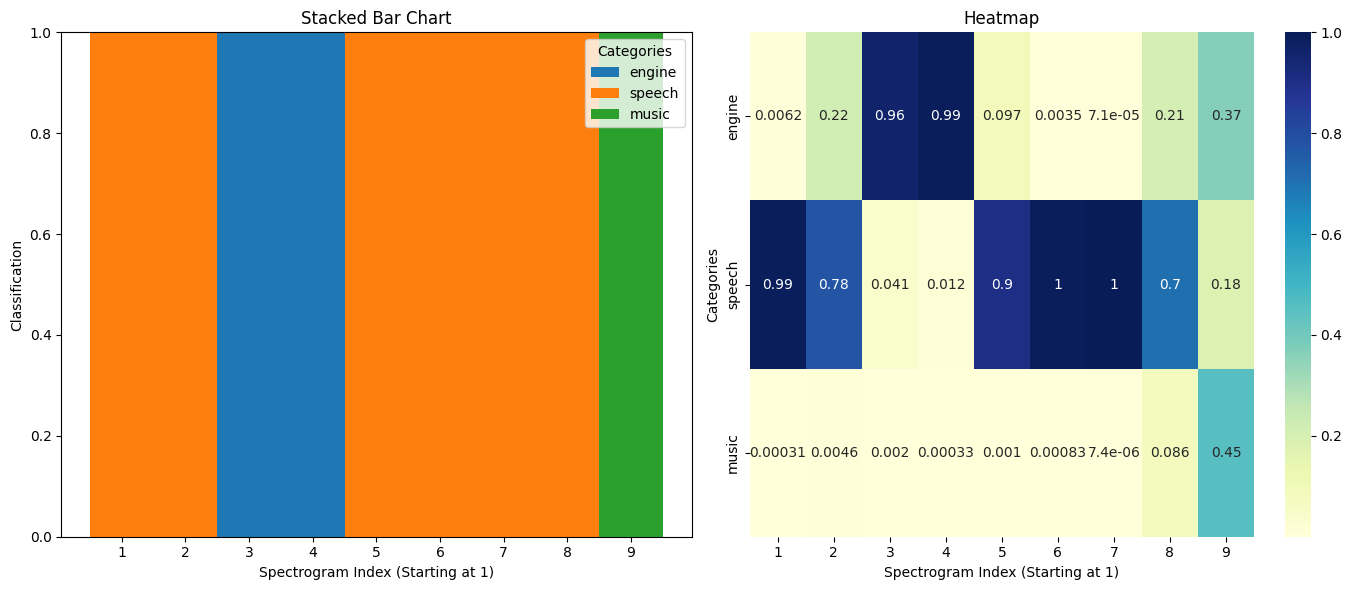

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model

def load_data_from_h5(h5_file):
    """
    Load spectrograms from an HDF5 file.

    Parameters:
        h5_file (str): Path to the HDF5 file containing spectrograms.

    Returns:
        np.ndarray: Loaded spectrograms as a NumPy array.
    """
    print(f"Loading spectrograms from {h5_file}...")
    try:
        with h5py.File(h5_file, "r") as hf:
            if "spectrograms" not in hf:
                raise ValueError("No 'spectrograms' dataset found in the HDF5 file.")
            spectrograms = hf["spectrograms"][:]
            print(f"Loaded {len(spectrograms)} spectrograms.")
    except Exception as e:
        raise RuntimeError(f"Error loading HDF5 file: {e}")
    return spectrograms

def classify_spectrograms(model_file, spectrograms):
    """
    Classify spectrograms using a trained model.

    Parameters:
        model_file (str): Path to the trained model file (.h5).
        spectrograms (np.ndarray): Input spectrograms to classify.

    Returns:
        np.ndarray: Predicted class probabilities for each spectrogram.
        np.ndarray: Predicted class labels.
    """
    print(f"Loading trained model from {model_file}...")
    try:
        model = load_model(model_file)
        print("Model loaded successfully.")
    except Exception as e:
        raise RuntimeError(f"Error loading model: {e}")

    # Ensure data has the correct shape for the model
    if len(spectrograms.shape) == 3:  # Add channel dimension if needed
        input_data = spectrograms[..., np.newaxis]
    else:
        input_data = spectrograms

    print("Classifying spectrograms...")
    predictions = model.predict(input_data, verbose=1)

    # Get predicted class labels
    predicted_labels = np.argmax(predictions, axis=1)
    return predictions, predicted_labels

def plot_classification_results_side_by_side(predicted_labels, predictions, class_names, seconds):
    """
    Plot classification results as a stacked bar chart and heatmap side by side.

    Parameters:
        predicted_labels (np.ndarray): Array of predicted class labels.
        predictions (np.ndarray): Predicted probabilities for each spectrogram.
        class_names (list): List of class names corresponding to label indices.
        seconds (list): Time points corresponding to spectrograms.
    """
    print("Plotting classification results side by side...")
    num_classes = len(class_names)
    num_spectrograms = len(predicted_labels)

    # One-hot encode the predictions for the bar chart
    class_counts = np.zeros((num_classes, num_spectrograms))
    for i, label in enumerate(predicted_labels):
        class_counts[label, i] = 1

    # Create a side-by-side figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Stacked Bar Chart
    bottom = np.zeros(num_spectrograms)
    for i, class_name in enumerate(class_names):
        axes[0].bar(seconds, class_counts[i], width=1.0, label=class_name, bottom=bottom)
        bottom += class_counts[i]
    axes[0].set_title("Stacked Bar Chart")
    axes[0].set_xlabel("Spectrogram Index (Starting at 1)")
    axes[0].set_ylabel("Classification")
    axes[0].set_xticks(seconds)
    axes[0].legend(title="Categories")

    # Heatmap
    sns.heatmap(predictions.T, annot=True, cmap="YlGnBu", ax=axes[1], xticklabels=seconds, yticklabels=class_names)
    axes[1].set_title("Heatmap")
    axes[1].set_xlabel("Spectrogram Index (Starting at 1)")
    axes[1].set_ylabel("Categories")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # File paths
    h5_data_file = "./data/spectrograms.h5"  # Input data HDF5 file
    model_file = "./data/cnn_2s_128x128_best.h5"  # Trained model file (.h5 format)

    # Class names (update as per your trained model's classes)
    class_names = ["engine", "speech", "music"]

    # Time points corresponding to spectrogram indices (starting at 1)
    num_spectrograms = 9
    seconds = np.arange(1, num_spectrograms + 1)  # Spectrograms at 1, 2, ..., 9

    try:
        # Load spectrogram data
        spectrograms = load_data_from_h5(h5_data_file)

        # Classify spectrograms
        predictions, predicted_labels = classify_spectrograms(model_file, spectrograms)

        # Plot results side by side
        plot_classification_results_side_by_side(predicted_labels, predictions, class_names, seconds)

    except Exception as e:
        print(f"An error occurred: {e}")